#Хід роботи

## Налаштування робочого середовища

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Встановлення сід генератору псевдовипадкових чисел

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## Завантаження набору даних FashionMNIST

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


## Відобразимо декілька зображень з набору даних


In [5]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

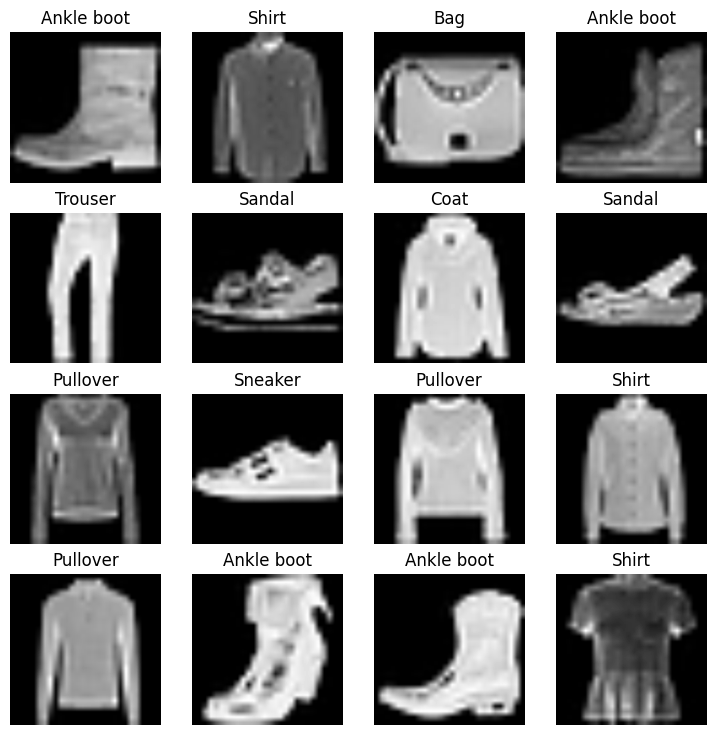

In [6]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Розділимо  набір даних на три вибірки: тренувальну, валідаційну та тестову

In [ ]:
# Divide the dataset into training, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Divide the dataset into label and unlabel sets
label_data = int(0.3 * len(train_dataset))
unlabel_data = len(train_dataset) - label_data
label_dataset, unlabel_dataset = torch.utils.data.random_split(train_dataset, [label_data, unlabel_data])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
label_dataloader = DataLoader(label_dataset, batch_size=BATCH_SIZE, shuffle=True)
unlabel_dataloader = DataLoader(unlabel_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Label images: {len(label_dataloader)* BATCH_SIZE}")
print(f"Unlabel images: {len(unlabel_dataloader)* BATCH_SIZE}")
print(f"Valid images: {len(valid_dataloader)* BATCH_SIZE}")
print(f"Test images: {len(test_dataloader)* BATCH_SIZE}")

Length of train dataloader: 1500 batches of 32
Label images: 14400
Unlabel images: 33600
Valid images: 12000
Test images: 10016
Length of train dataloader: 1500 batches of 32
Label images: 14400
Unlabel images: 33600
Valid images: 12000
Test images: 10016


## Налаштуємо нейронної мережі AlexNet

In [ ]:
# Download and configure AlexNet
import torchvision.models as models

model = models.alexnet(pretrained=False)
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6]=nn.Linear(4096, len(class_names))
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Навчання моделі

In [ ]:
def train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, epochs, device):

    # Dictionary to store results
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterate through the training dataloader
        for inputs, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_dataloader)
        train_acc = 100 * correct_train / total_train

        # Store training results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        # Iterate through the validation dataloader
        with torch.no_grad():
            for inputs, labels in tqdm(valid_dataloader, desc=f'Epoch {epoch + 1}/{epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation metrics
        val_loss = running_loss / len(valid_dataloader)
        val_acc = 100 * correct_val / total_val

        # Store validation results
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Print epoch-wise training and validation metrics
        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return results


In [ ]:
def plot_model(history):
  train_accs, val_accs, train_losses, val_losses = history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_acc'], label='Train')
  plt.plot(history['val_acc'], label='Validation')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_loss'], label='Train')
  plt.plot(history['val_loss'], label='Validation')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = train(model=model,
                train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

Epoch 1/10 - Validation: 100%|██████████| 375/375 [00:16<00:00, 22.38it/s]


Epoch [1/10] - Train Loss: 0.6603, Train Accuracy: 75.36% - Validation Loss: 0.3945, Validation Accuracy: 85.41%


Epoch 2/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 27.58it/s]


Epoch [2/10] - Train Loss: 0.4380, Train Accuracy: 84.16% - Validation Loss: 0.3825, Validation Accuracy: 85.60%


Epoch 3/10 - Validation: 100%|██████████| 375/375 [00:12<00:00, 29.07it/s]


Epoch [3/10] - Train Loss: 0.3892, Train Accuracy: 85.69% - Validation Loss: 0.3277, Validation Accuracy: 87.94%


Epoch 4/10 - Validation: 100%|██████████| 375/375 [00:12<00:00, 30.30it/s]


Epoch [4/10] - Train Loss: 0.3638, Train Accuracy: 86.65% - Validation Loss: 0.3311, Validation Accuracy: 87.38%


Epoch 5/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 27.35it/s]


Epoch [5/10] - Train Loss: 0.3421, Train Accuracy: 87.50% - Validation Loss: 0.2892, Validation Accuracy: 89.26%


Epoch 6/10 - Validation: 100%|██████████| 375/375 [00:14<00:00, 25.67it/s]


Epoch [6/10] - Train Loss: 0.3351, Train Accuracy: 87.53% - Validation Loss: 0.2874, Validation Accuracy: 89.14%


Epoch 7/10 - Validation: 100%|██████████| 375/375 [00:14<00:00, 26.69it/s]


Epoch [7/10] - Train Loss: 0.3240, Train Accuracy: 88.24% - Validation Loss: 0.2981, Validation Accuracy: 89.08%


Epoch 8/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 28.30it/s]


Epoch [8/10] - Train Loss: 0.3143, Train Accuracy: 88.46% - Validation Loss: 0.2771, Validation Accuracy: 89.75%


Epoch 9/10 - Validation: 100%|██████████| 375/375 [00:12<00:00, 29.23it/s]


Epoch [9/10] - Train Loss: 0.3112, Train Accuracy: 88.60% - Validation Loss: 0.3042, Validation Accuracy: 88.76%


Epoch 10/10 - Validation: 100%|██████████| 375/375 [00:14<00:00, 26.41it/s]

Epoch [10/10] - Train Loss: 0.3022, Train Accuracy: 88.91% - Validation Loss: 0.2718, Validation Accuracy: 90.07%



Epoch 1/10 - Validation: 100%|██████████| 375/375 [00:14<00:00, 25.23it/s]


Epoch [1/10] - Train Loss: 0.6396, Train Accuracy: 76.44% - Validation Loss: 0.3988, Validation Accuracy: 85.70%


Epoch 2/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 27.45it/s]


Epoch [2/10] - Train Loss: 0.4366, Train Accuracy: 83.88% - Validation Loss: 0.3503, Validation Accuracy: 86.70%


Epoch 3/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 28.46it/s]


Epoch [3/10] - Train Loss: 0.3903, Train Accuracy: 85.58% - Validation Loss: 0.3473, Validation Accuracy: 87.18%


Epoch 4/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 28.41it/s]


Epoch [4/10] - Train Loss: 0.3665, Train Accuracy: 86.46% - Validation Loss: 0.3003, Validation Accuracy: 88.61%


Epoch 5/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 28.11it/s]


Epoch [5/10] - Train Loss: 0.3431, Train Accuracy: 87.24% - Validation Loss: 0.2881, Validation Accuracy: 89.23%


Epoch 6/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 26.96it/s]


Epoch [6/10] - Train Loss: 0.3257, Train Accuracy: 87.99% - Validation Loss: 0.2862, Validation Accuracy: 89.02%


Epoch 7/10 - Validation: 100%|██████████| 375/375 [00:14<00:00, 26.53it/s]


Epoch [7/10] - Train Loss: 0.3229, Train Accuracy: 88.06% - Validation Loss: 0.3108, Validation Accuracy: 88.31%


Epoch 8/10 - Validation: 100%|██████████| 375/375 [00:13<00:00, 28.64it/s]


Epoch [8/10] - Train Loss: 0.3067, Train Accuracy: 88.67% - Validation Loss: 0.2775, Validation Accuracy: 89.43%


Epoch 9/10 - Validation: 100%|██████████| 375/375 [00:12<00:00, 29.14it/s]


Epoch [9/10] - Train Loss: 0.3027, Train Accuracy: 88.99% - Validation Loss: 0.2571, Validation Accuracy: 90.58%


Epoch 10/10 - Validation: 100%|██████████| 375/375 [00:14<00:00, 26.17it/s]

Epoch [10/10] - Train Loss: 0.2906, Train Accuracy: 89.24% - Validation Loss: 0.2529, Validation Accuracy: 90.58%


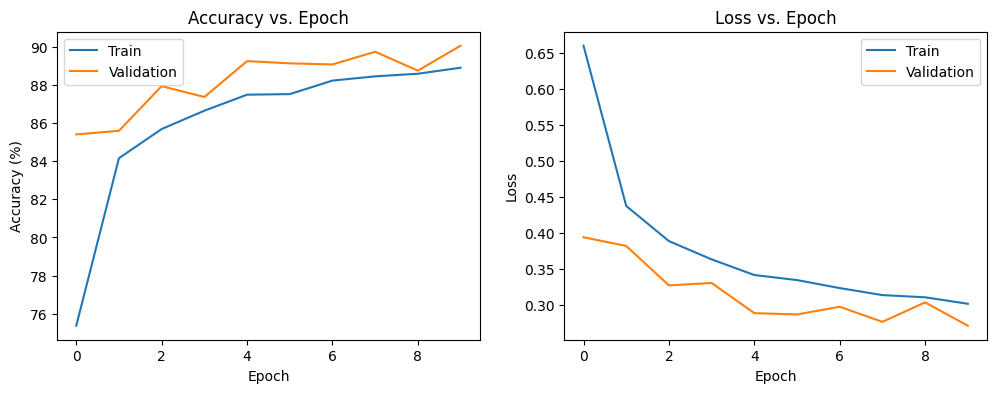

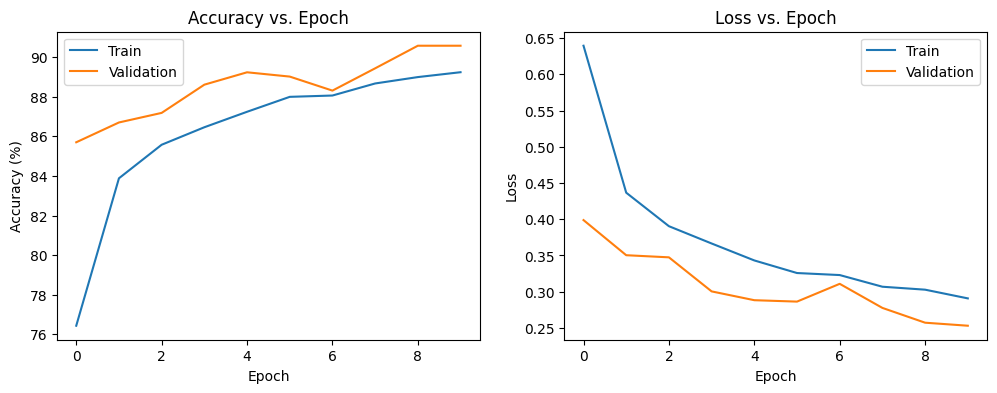

In [ ]:
plot_model(results)

## Збереження ваг моделі у файл

In [ ]:
torch.save(model.state_dict(), 'lab2_all_data.pth')

## Навчання моделі напівкерованим алгоритмом Noisy Student

In [ ]:
class CombineDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset, pseudo_labels, augmentation_transform=None):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.pseudo_labels = pseudo_labels
        self.augmentation_transform = augmentation_transform

    def __len__(self):
        return len(self.labeled_dataset) + len(self.unlabeled_dataset)

    def __getitem__(self, index):
        if index < len(self.labeled_dataset):
            labeled_data, labels = self.labeled_dataset[index]

            # Apply augmentation transforms to labeled data
            if self.augmentation_transform:
                labeled_data = self.augmentation_transform(labeled_data)

            return labeled_data, labels
        else:
            # Adjust the index for the unlabeled data
            unlabeled_index = index - len(self.labeled_dataset)
            unlabeled_data, _ = self.unlabeled_dataset[unlabeled_index]

            # Apply augmentation transforms to unlabeled data
            if self.augmentation_transform:
                unlabeled_data = self.augmentation_transform(unlabeled_data)

            pseudo_label = self.pseudo_labels[unlabeled_index]
            return unlabeled_data, pseudo_label

In [ ]:
def train(teacher_model, student_model,
          label_dataloader, unlabel_dataloader, valid_dataloader,
          augmentation_transform, optimizer_t, optimizer_s,
          loss_fn, device):

    # Set teacher model to training mode
    teacher_model.train()

    # Initialize variables to track training statistics
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate over labeled data for teacher model training
    for labeled_data, labels in tqdm(label_dataloader):
        labeled_data, labels = labeled_data.to(device), labels.to(device)
        optimizer_t.zero_grad()

        # Forward pass and compute loss for teacher model
        outputs = teacher_model(labeled_data)
        loss_t = loss_fn(outputs, labels)
        loss_t.backward()
        optimizer_t.step()

        # Update training statistics
        running_loss += loss_t.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for teacher model
    train_loss = running_loss / len(label_dataloader)
    train_acc = 100 * correct_train / total_train

    # Switch teacher model to evaluation mode for pseudo-labeling
    teacher_model.eval()
    pseudo_labels = []

    # Generate pseudo-labels for unlabeled data using teacher model
    for data_unlabeled, _ in unlabel_dataloader:
        with torch.no_grad():
            data_unlabeled = data_unlabeled.to(device)
            outputs = teacher_model(data_unlabeled)
            _, predicted = torch.max(outputs.data, 1)
            pseudo_labels.extend(predicted.tolist())

    # Concatenate labeled and unlabeled data into a combined dataset
    combined_dataset = CombineDataset(label_dataset, unlabel_dataset, pseudo_labels)
    combined_dataloader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Set student model to training mode
    student_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate over combined dataset for student model training
    for inputs, labels in tqdm(combined_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Train student model on combined dataset
        optimizer_s.zero_grad()
        outputs = student_model(inputs)
        loss_s = loss_fn(outputs, labels)
        loss_s.backward()
        optimizer_s.step()

        # Update training statistics for student model
        running_loss += loss_s.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for student model
    student_loss = running_loss / len(combined_dataloader)
    student_acc = 100 * correct_train / total_train

    # Switch student model to evaluation mode for validation
    student_model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    # Evaluate student model on validation dataset
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = student_model(inputs)
            loss_s = loss_fn(outputs, labels)
            running_loss += loss_s.item()

            # Update validation statistics
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss = running_loss / len(valid_dataloader)
    val_acc = 100 * correct_val / total_val

    # Return updated teacher model, student model, and training/validation statistics
    return teacher_model, student_model, (student_loss, student_acc, val_loss, val_acc)


In [ ]:
# Training loop function for the Noisy Student approach
def noisy_student_train(label_dataloader, unlabel_dataloader, valid_dataloader, epochs, device):

    # Dictionary to store training and validation results
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
              }

    # Create a teacher model based on AlexNet architecture
    teacher_model = models.alexnet(pretrained=False)
    teacher_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
    teacher_model.classifier[6] = nn.Linear(4096, len(class_names))
    teacher_model.to(device)

    # Create a student model based on AlexNet architecture
    student_model = models.alexnet(pretrained=False)
    student_model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
    student_model.classifier[6] = nn.Linear(4096, len(class_names))
    student_model.to(device)

    # Define cross-entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # Initialize Adam optimizers for teacher and student models
    optimizer_teacher = torch.optim.Adam(teacher_model.parameters(), lr=0.001)
    optimizer_student = torch.optim.Adam(student_model.parameters(), lr=0.001)

    # Define data augmentation transforms
    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Training the models using the Noisy Student approach
    for epoch in range(epochs):
        print(f"Epoch [{epoch + 1}/{epochs}]")

        # Train both teacher and student models
        student_model, teacher_model, metrics = train(teacher_model,
                                                      student_model,
                                                      label_dataloader,
                                                      unlabel_dataloader,
                                                      valid_dataloader,
                                                      augmentation_transform,
                                                      optimizer_teacher,
                                                      optimizer_student,
                                                      loss_fn,
                                                      device)

        # Retrieve training metrics for logging and storage
        train_loss, train_acc, val_loss, val_acc = metrics

        # Store results in the dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Print training and validation results for the current epoch
        print(f"Train loss: {train_loss:.4f}, train accuracy: {train_acc:.2f}% - "
              f"Validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.2f}%")

    # Save the trained student model
    torch.save(student_model.state_dict(), 'noisy_student.pth')

    # Return the results dictionary
    return results


In [ ]:
epochs = 10
results = noisy_student_train(label_dataloader, unlabel_dataloader, valid_dataloader, epochs, device)

Epoch [1/10]


100%|██████████| 1500/1500 [01:38<00:00, 15.28it/s]


Train loss: 0.5849, train accuracy: 78.81% - Validation loss: 0.5793, validation accuracy: 79.67%
Epoch [2/10]


100%|██████████| 1500/1500 [01:12<00:00, 20.58it/s]


Train loss: 0.5815, train accuracy: 81.35% - Validation loss: 0.6055, validation accuracy: 78.84%
Epoch [3/10]


100%|██████████| 1500/1500 [01:36<00:00, 15.50it/s]


Train loss: 0.3930, train accuracy: 86.05% - Validation loss: 0.5170, validation accuracy: 82.44%
Epoch [4/10]


100%|██████████| 1500/1500 [01:13<00:00, 20.47it/s]


Train loss: 0.4267, train accuracy: 84.60% - Validation loss: 0.4599, validation accuracy: 82.91%
Epoch [5/10]


100%|██████████| 1500/1500 [01:34<00:00, 15.81it/s]


Train loss: 0.3604, train accuracy: 87.03% - Validation loss: 0.4784, validation accuracy: 81.92%
Epoch [6/10]


100%|██████████| 1500/1500 [01:12<00:00, 20.56it/s]


Train loss: 0.3732, train accuracy: 86.87% - Validation loss: 0.4885, validation accuracy: 82.02%
Epoch [7/10]


100%|██████████| 1500/1500 [01:35<00:00, 15.67it/s]


Train loss: 0.3500, train accuracy: 87.63% - Validation loss: 0.4107, validation accuracy: 85.52%
Epoch [8/10]


100%|██████████| 1500/1500 [01:11<00:00, 21.09it/s]


Train loss: 0.3986, train accuracy: 86.89% - Validation loss: 0.4397, validation accuracy: 83.67%
Epoch [9/10]


100%|██████████| 1500/1500 [01:35<00:00, 15.64it/s]


Train loss: 0.3176, train accuracy: 88.76% - Validation loss: 0.4000, validation accuracy: 85.42%
Epoch [10/10]


100%|██████████| 1500/1500 [01:14<00:00, 20.20it/s]


Train loss: 0.3342, train accuracy: 88.57% - Validation loss: 0.3867, validation accuracy: 85.48%
Epoch [1/10]


100%|██████████| 1500/1500 [01:36<00:00, 15.48it/s]


Train loss: 0.5439, train accuracy: 80.71% - Validation loss: 0.5868, validation accuracy: 81.02%
Epoch [2/10]


100%|██████████| 1500/1500 [01:11<00:00, 21.04it/s]


Train loss: 0.4567, train accuracy: 84.06% - Validation loss: 0.5251, validation accuracy: 79.53%
Epoch [3/10]


100%|██████████| 1500/1500 [01:37<00:00, 15.44it/s]


Train loss: 0.3672, train accuracy: 87.14% - Validation loss: 0.4898, validation accuracy: 83.97%
Epoch [4/10]


100%|██████████| 1500/1500 [01:14<00:00, 20.22it/s]


Train loss: 0.3496, train accuracy: 87.84% - Validation loss: 0.4337, validation accuracy: 84.08%
Epoch [5/10]


100%|██████████| 1500/1500 [01:36<00:00, 15.52it/s]


Train loss: 0.3267, train accuracy: 88.58% - Validation loss: 0.4025, validation accuracy: 85.36%
Epoch [6/10]


100%|██████████| 1500/1500 [01:13<00:00, 20.53it/s]


Train loss: 0.3190, train accuracy: 89.03% - Validation loss: 0.3913, validation accuracy: 85.61%
Epoch [7/10]


100%|██████████| 1500/1500 [01:36<00:00, 15.49it/s]


Train loss: 0.3048, train accuracy: 89.00% - Validation loss: 0.4219, validation accuracy: 85.22%
Epoch [8/10]


100%|██████████| 1500/1500 [01:13<00:00, 20.40it/s]


Train loss: 0.3097, train accuracy: 89.30% - Validation loss: 0.3899, validation accuracy: 85.66%
Epoch [9/10]


100%|██████████| 1500/1500 [01:35<00:00, 15.63it/s]


Train loss: 0.3143, train accuracy: 88.58% - Validation loss: 0.3793, validation accuracy: 85.98%
Epoch [10/10]


100%|██████████| 1500/1500 [01:12<00:00, 20.77it/s]


Train loss: 0.3550, train accuracy: 87.80% - Validation loss: 0.3891, validation accuracy: 85.54%


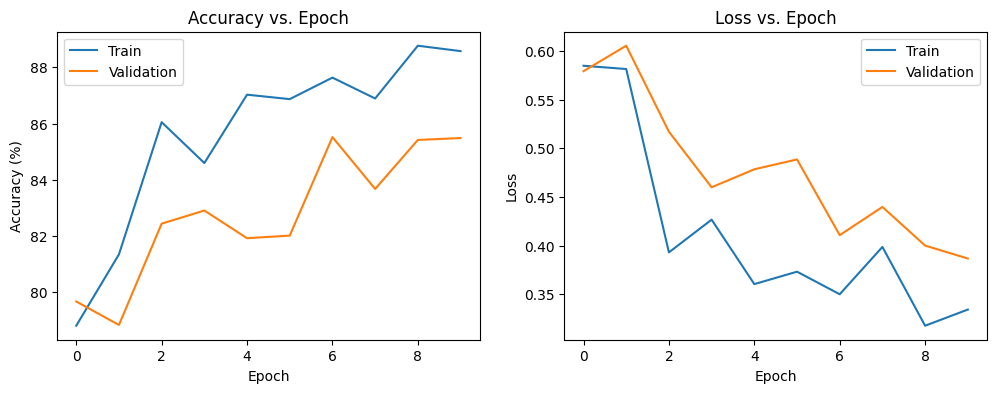

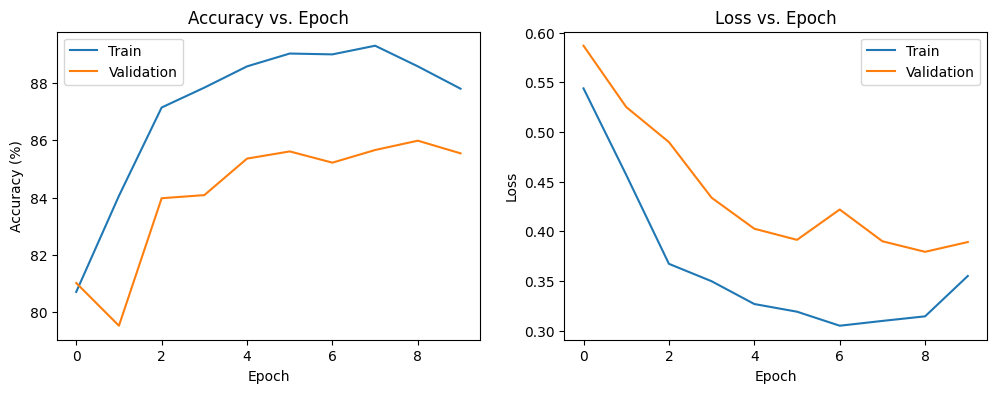

In [ ]:
plot_model(results)

# Висновок


Підсумовуючи, порівняння стандартного методу навчання під наглядом і напівконтрольованого підходу до навчання Noisy Student відкриває цікаві висновки. У стандартному методі навчання була досягнута точність перевірки 90,58%, що вказує на високу ефективність набору перевірки. З іншого боку, напівконтрольований метод Noisy Student дав точність перевірки 85,98%.

Хоча стандартний підхід до навчання перевершив метод Noisy Student з точки зору точності перевірки, важливо враховувати контекст і потенційні компроміси. Підхід Noisy Student часто використовує комбінацію позначених і не позначених даних, включаючи псевдомітки, згенеровані моделлю викладача. Незважаючи на дещо нижчу точність перевірки, метод Noisy Student може запропонувати переваги в сценаріях, де мічених даних мало.

Підводячи підсумок, можна сказати, що вибір між стандартним навчанням під наглядом і напівконтрольованим навчанням Noisy Student залежить від конкретних вимог і обмежень поставленого завдання. Обидва методи мають свої сильні сторони, і рішення має ґрунтуватися на ретельному розгляді наявних даних і бажаному балансі між продуктивністю моделі та ефективністю даних.